# Case para vaga de Estágio em Risco



**Malcolm dos Reis Alves Pereira**

### Objetivo

Esse projeto está sendo feito com o objetivo de validar minhas habilidades na linguagem em SQL para o processo seletivo.


### Conexão e Banco de Dados

Importando as bibliotecas necessárias para a execução da atividade

In [ ]:
import duckdb as db # Usar os comandos sql
import pandas as pd # Ler a planilha original

Como o objetivo do projeto é verificar as minhas habilidades com os comandos em SQL, nessa atividade vamos utilizar o DuckDB que oferece uma vasta gama de funcionalidades dessa linguagem.

A escolha dessa ferramenta foi feita pois ela, além da possibilidade fazer uma conexão com um banco de dados que ainda não existe, suporta comandos que deixam todo o código mais limpo (os citados nas dicas presentes no enunciado desse case) e que são suportados em todos os sistemas de gerenciamento de banco de dados.

Vamos iniciar o projeto fazendo a leitura dos dados contidos na planilha "Consultas" do arquivo enviado, onde estão os dados em formato wide (as variáveis estão desempilhadas)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Lendo os dados (para reproduzir, ajuste o caminho da pasta em que o arquivo com os dados esta)
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/case_supplier/Teste SQL.xlsx", sheet_name="Consultas")
df

,CLIENTE,DATA,CONSULTA1,CONSULTA2,CONSULTA3,CONSULTA4,CONSULTA5,CONSULTA6,CONSULTA7,CONSULTA8,CONSULTA9,CONSULTA10,CONSULTA11
0,JOÃO,2024-06-04,15,5,4,1,1,5,9,2,0,1,0


Assim, é necessário fazer a conexão com algum banco de dados para podermos inserir e manipular as tabelas necessárias nele.

In [ ]:
conn = db.connect("casesupplier") # Fazendo a conexao

In [ ]:
conn.execute("CREATE OR REPLACE TABLE consultas AS SELECT * FROM df") # Colocando a tabela original no banco de dados
conn.execute("SELECT * FROM consultas").fetchdf() # Query basica

,CLIENTE,DATA,CONSULTA1,CONSULTA2,CONSULTA3,CONSULTA4,CONSULTA5,CONSULTA6,CONSULTA7,CONSULTA8,CONSULTA9,CONSULTA10,CONSULTA11
0,JOÃO,2024-06-04,15,5,4,1,1,5,9,2,0,1,0


### Tranformando a tabela em formato longo

Para conseguirmos ajustar as retas de regressão linear e obtermos os interceptos e as inclinações delas, é necessário transformar essa tabela wide em uma tabela com formato longo, onde cada variável é uma coluna. Temos que, então, basicamente, colocar as observações de cada consulta (que estão dispostas em linha) em função da variável "CONSULTA" definida nesse momento, resultando assim, em uma coluna "CONSULTA" e uma coluna "OBS" (de "observação").

Além disso, temos que deixar a coluna que contém o número da consulta numérica. Faremos isso, após deixar a tabela em formato longo, retirando os caracteres das observações da coluna CONSULTA, deixando apenas o número da consulta e convertendo a coluna para INT (para ser possível utilizar a função REGR_SLOPE e REGR_INTECEPT posteriormente).

In [ ]:
# Colocar as observacoes em funcao da consulta usando as colunas
# "Consulta1", "Consulta2", ... da tabela "consultas";

# Substitundo a palavra "CONSULTA" presente nas observacoes da variavel
# "CONSULTA" por nada (removendo os caracteres e deixando so o numero);

# Convertento a variavel "CONSULTA" para numerica com esta coluna apresentando
# apenas os numeros da respectiva consulta.

conn.execute("""CREATE OR REPLACE TABLE consultas_long AS
             (SELECT CLIENTE,DATA,CAST(REGEXP_REPLACE(CONSULTA, 'CONSULTA', '') AS INTEGER) AS CONSULTA,OBS
              FROM consultas
              UNPIVOT
              (OBS FOR CONSULTA IN
              (Consulta1,Consulta2,Consulta3, Consulta4,Consulta5,Consulta6,Consulta7,Consulta8,Consulta9,Consulta10,Consulta11)))""")

conn.execute("SELECT * FROM consultas_long").fetchdf() # Query basica

,CLIENTE,DATA,CONSULTA,OBS
0,JOÃO,2024-06-04,1,15
1,JOÃO,2024-06-04,2,5
2,JOÃO,2024-06-04,3,4
3,JOÃO,2024-06-04,4,1
4,JOÃO,2024-06-04,5,1
5,JOÃO,2024-06-04,6,5
6,JOÃO,2024-06-04,7,9
7,JOÃO,2024-06-04,8,2
8,JOÃO,2024-06-04,9,0
9,JOÃO,2024-06-04,10,1


### Ajuste da reta de regressão linear

Agora que temos a tabela no formato longo, podemos ajustar uma reta de regressão linear que segue o seguinte modelo:

𝘠 = a𝘟 + b

Sendo o "b" o intercepto, o "a" a inclinação da reta, o Y as observações (variável resposta) e o X a consulta (a variável preditora).

Para isso, foi utilizadas as funções REGR_SLOPE e REGR_INTECEPT que considera que a reta esta sendo ajustada pelo Método dos Mínimos Quadrados para realizar o cálculo desses parâmetros (inclinação e intercepto, respectivamente).

In [ ]:
# Criar uma classe que identifica quando a consulta e menor ou igual a 3 e
# e quando e maior ou igual a 4

# Extrair a inclinacao e o intercepto da reta agrupando as observacoes pela
# classe criada

# Pegando o resultado com apenas dois numeros decimais

conn.execute("""SELECT classe_consultas,
                       ROUND(REGR_SLOPE(OBS,CONSULTA),2) AS inclinacao,
                       ROUND(REGR_INTERCEPT(OBS,CONSULTA),2) AS intercepto
                FROM
                (SELECT *,
                CASE WHEN CONSULTA BETWEEN 4 AND 11 THEN '4-11'
                ELSE '1-3'
                END AS classe_consultas
                FROM consultas_long)
                GROUP BY classe_consultas""").fetchdf()

,classe_consultas,inclinacao,intercepto
0,1-3,-5.50,19.00
1,4-11,-0.35,4.96


Nesse caso, temos para as três primeiras consultas, temos o intercepto igual a 19 e a inclinação da reta igual a -5.5, sendo, então, o ajuste da reta dado por:

𝘠 = -5.50 *⋅* 𝘟 + 19.00

E para o outro caso, para as consultas que ocorreram depois da terceira consulta, temos uma reta ajustada dada por:

𝘠 = -0.35 ⋅ 𝘟 + 4.96

### Soma das observações

Além do ajuste das retas de regressão linear, foi pedido que fosse entregue a soma das observações das seis primeiras consultas.

Para esse procedimento, utilizamos a função de soma do SQL (SUM) nas observações condicionando apenas àquelas as quais o número da consulta estivesse entre 1 e 6.

Temos, então, que a soma das 6 primeiras consultas é igual a 31.

In [ ]:
# Somar (SUM) apenas as observacoes onde (WHERE) o numero da consulta esta
# entre (BETWEEN) 1 e 6

conn.execute("""SELECT SUM(OBS) AS SOMA
            FROM consultas_long
            WHERE CONSULTA BETWEEN 1 AND 6""").fetchdf()

,SOMA
0,31.0


### Finalização

Já tendo obtido todas as medidas que nos interessavam neste banco de dados, podemos fechar a conexão feita.

In [ ]:
# Guardando o dataframe para usarmos na analise grafica
df_long = conn.execute("SELECT * FROM consultas_long").fetchdf()
medidas = conn.execute("""SELECT classe_consultas,
                       ROUND(REGR_SLOPE(OBS,CONSULTA),2) AS inclinacao,
                       ROUND(REGR_INTERCEPT(OBS,CONSULTA),2) AS intercepto
                FROM
                (SELECT *,
                CASE WHEN CONSULTA BETWEEN 4 AND 11 THEN '4-11'
                ELSE '1-3'
                END AS classe_consultas
                FROM consultas_long)
                GROUP BY classe_consultas""").fetchdf()

In [ ]:
conn.close() # Fechando a conexao

### Extra: Análise Gráfica


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Text(0, 0.5, 'Observação')

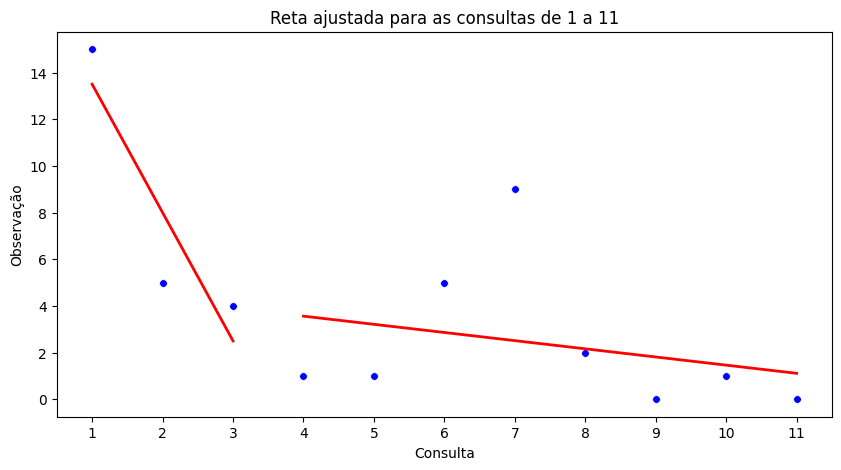

In [ ]:
# Dfs filtrados
df_filtered1 = df_long[df_long['CONSULTA'].isin(range(1, 4))]
df_filtered2 = df_long[df_long['CONSULTA'].isin(range(4, 12))]

# Criar do grafico
plt.figure(figsize=(10, 5))

# Calcular os valores y para a linha usando a equacao da reta
x1_val = df_filtered1['CONSULTA']
y1_val = medidas.iloc[0][2] + medidas.iloc[0][1] * x1_val

x2_val = df_filtered2['CONSULTA']
y2_val = medidas.iloc[1][2] + medidas.iloc[1][1] * x2_val


# Plot da reta
plt.plot(x1_val, y1_val, color='red', linewidth=2)
plt.plot(x2_val, y2_val, color='red', linewidth=2)

# Grafico de pontos
sns.scatterplot(data=df_filtered1, x='CONSULTA', y='OBS', color='blue', s=30)
sns.scatterplot(data=df_filtered2, x='CONSULTA', y='OBS', color='blue', s=30)

# Ajustar o eixo x
plt.xticks(ticks=range(1,12))

plt.title('Reta ajustada para as consultas de 1 a 11')
plt.xlabel('Consulta')
plt.ylabel('Observação')

Apesar de que, olhando para o segundo gráfico, eu não considero que exista uma associação linear entre as observações e o número da consulta, utilizando as retas como uma forma de analisar a taxa de decaimento das observações em função do número da consulta, pode-se observar que essa taxa diminui com o aumento do número das consultas. Isto é, se num primeiro momento (nas primeiras consultas) tivemos uma queda brusca de observações, no segundo momento (nas consultas 4 a 11) isso já não aconteceu, havendo até aumento das obsevações em um determinado intervalo.